# SUMMARY
In this notebook we focus on producing some standard graphs to chart how the number of cases and deaths vary over time for each country. Since the outbreak hit different countries at differet times. For the earliest cases (in our ECDC dataset) date back to teh end of December 2019, from China, and in general countries in Asia were impacted earlier than Europe and the rest of the world. These timing differences make it a little trickier to compare how cases/deaths progressed between countries whose outbreaks are separated in time by days or weeks.

To deal with this, instead of comparing countries by date, we compare countries based on an agreed common day in the progression of the outbreak. By common agreement we assign calculate day-0 for a country based on the date that its number of cases reached 100 or above. When we consider deaths we use the date that the number of deaths reached 10 as a country's day-0 date.

In this way we can compare countries based on the number of days since their day-0 date (for cases or deaths), making it possible to draw comparisons for countries at similar stages during their local outbreaks.

Shoutout to https://www.ft.com/coronavirus-latest for the very nice graphs on the coronavirus; I've borrowed heavily from their visualisations to produce the graphs in this notebook.

In [1]:
from datetime import date

import pandas as pd
import numpy as np

from matplotlib.pylab import plt

import seaborn as sns

sns.set_style("white")
sns.set_context('talk')

%matplotlib inline

# Load the Processed DataSet

In [2]:
ecdc_dataset_processed = '../data/processed/ecdc_dataset.csv'
graphs_dir = '../graphs/'

In [3]:
df = pd.read_csv(ecdc_dataset_processed)

df.head()



,country,day,date,month,year,cases,deaths,id,code,pop,cum_cases,cum_deaths,cum_cases_pct_change,cum_deaths_pct_change,cum_cases_log10,cum_deaths_log10,cum_cases_dt,day_zero_cases,day_zero_deaths
0,New_Zealand,0,2019-12-31,12,2019,0,0,NZ,NZL,4.885500e+06,0,0,NaN,NaN,NaN,NaN,NaN,-83.0,NaN
1,Philippines,0,2019-12-31,12,2019,0,0,PH,PHL,1.066519e+08,0,0,NaN,NaN,NaN,NaN,NaN,-75.0,-76.0
2,Ireland,0,2019-12-31,12,2019,0,0,IE,IRL,4.853506e+06,0,0,NaN,NaN,NaN,NaN,NaN,-75.0,NaN
3,India,0,2019-12-31,12,2019,0,0,IN,IND,1.352617e+09,0,0,NaN,NaN,NaN,NaN,NaN,-77.0,-86.0
4,San_Marino,0,2019-12-31,12,2019,0,0,SM,SMR,3.378500e+04,0,0,NaN,NaN,NaN,NaN,NaN,-77.0,-78.0


# Plotting Number of Cases/Deaths x Day for Countries

## Setup


In [4]:
# Used for our graphs title.
todays_date = "-{}-{:02}-{:02}".format(date.today().year, date.today().month, date.today().day)

# One of Matplotlib's standard colour maps.
colours = plt.cm.tab20(np.linspace(0,1,20))

# All of the countries in the dataset.
all_countries = df['country'].unique()

# The top 10 countries with the longest outbreaks so far.
longest_10_countries_by_cases = set(df.groupby('country')['day_zero_cases'].apply(lambda g: len(g[g>0])).sort_values(ascending=False).head(10).index.values)

# Countries we wil highlight in our graphs and their corresponding colour maps.
# highlight_countries = set([*longest_10_countries_by_cases, 'Ireland', 'United_Kingdom'])
highlight_countries = [
    'Ireland', 'United_Kingdom', 'Italy', 'France', 'Spain', 'Germany', 
    'United_States_of_America', 'Canada', 'Japan', 'Singapore', 'South_Korea', 'China'
]
highlight_colour_dict = dict(zip(highlight_countries, colours))


In [5]:
def plot_simple_country_by_day(ax, s, **kwargs):
    
    """Generate a basic line  for a single country.
    
    Args:
        ax - plot axis
        s - the series data with, for example, cumulative cases/deaths for the target country.
    """

    if 0 in s.index:
        s = s.loc[0:]

        x, y = s.index.values, s.values

        ax.plot(x, y, **kwargs)


In [6]:
def plot_country_by_day(ax, s, label=None, **kwargs):
    
    """Generate a basic line plot for a single country with markers and annotation.
    
    Args:
        ax - plot axis
        s - the series data with, for example, cumulative cases/deaths for the target country.
        label - the country name to use to label the line is provided.
    """
    
    # It is assumed that s is a series of cumulative cases/deaths data that is indexed on
    # the corresponding day-0 data. We can only plot for a country that has reached its day-0 thershold.
    if 0 in s.index:
        
        # Only plot the data from day-0
        s = s.loc[0:]
    
        x, y = s.index.values, s.values

        # For a more attractive presentation we plot a standard libe graph with outline markers, followed
        # by the same data plotted as a scatter plot with filled (smaller) markers that will fit inside
        # the outline markers.
        ax.plot(x, y, lw=.75, marker='o', markersize=9, markerfacecolor='none', markeredgewidth=.5, **kwargs)
        ax.plot(x, y, lw=0, marker='o', markersize=2, **kwargs)
        
        # Highlight the most recent datapoint.
        ax.plot([x[-1]], [y[-1]], marker='o', markersize=10, markerfacecolor='none', markeredgewidth=2, **kwargs)
        
        # If a label is provided then annotate the corresponding line-graph.
        if label is not None:
            ax.annotate(label.replace('_', ' '), xy=(x[-1]+1, y[-1]), fontsize=12)
    
    
    

# Number of Cases x Country x Days Since 100th Case

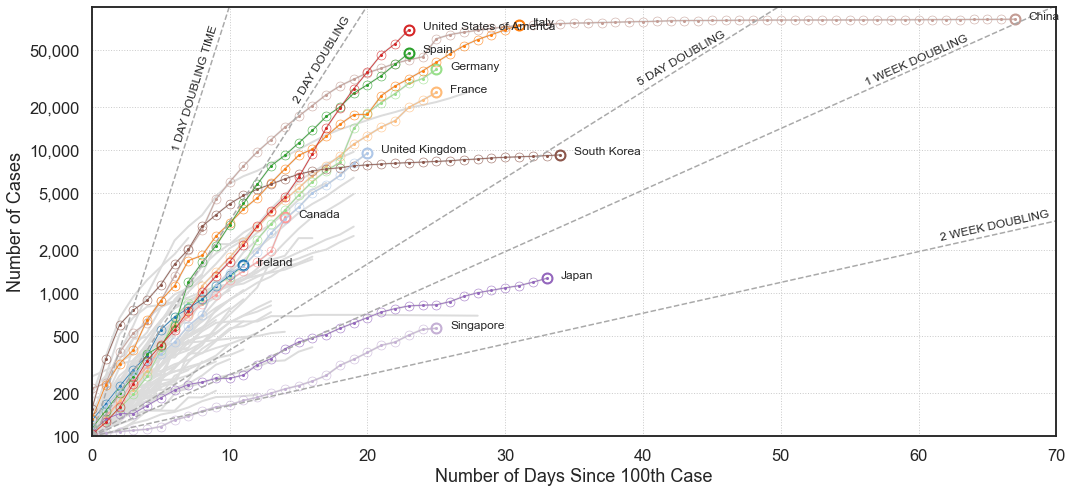

In [7]:
day_zero_col, cum_col = 'day_zero_cases', 'cum_cases_log10'


fig, ax = plt.subplots(figsize=(15, 7))

# Plot for all countries but using a faded grey; this plot effectively serves as an unlabaled background to 
# create a sense of how the other countries are progressing.
df[df['country'].isin(all_countries)].groupby('country').apply(
    lambda g: plot_simple_country_by_day(ax, g.set_index(day_zero_col)[cum_col], lw=2, c='gainsboro', alpha=1)
)

# An annotated plot for the set of highlight countries.
df[df['country'].isin(highlight_countries)].groupby('country').apply(
    lambda g: plot_country_by_day(ax, g.set_index(day_zero_col)[cum_col], label=g.name, c=highlight_colour_dict[g.name])
)


# Add the doubling-time indicators
def doubling_time(e, d):
    x = np.arange(0, e, d)
    y = np.log10((2**(x/d))*100)
    return x, y

for d in [1, 2, 5, 7, 14]: ax.plot(*doubling_time(71, d), c='darkgrey', lw=1.5, ls='--')

ax.annotate("1 DAY DOUBLING TIME", xy=(5.75, 4), fontsize=12, rotation=73)
ax.annotate("2 DAY DOUBLING", xy=(14.5, 4.33), fontsize=12, rotation=59)
ax.annotate("5 DAY DOUBLING", xy=(39.5, 4.45), fontsize=12, rotation=30)
ax.annotate("1 WEEK DOUBLING", xy=(56, 4.45), fontsize=12, rotation=24)
ax.annotate("2 WEEK DOUBLING", xy=(61.5, 3.37), fontsize=12, rotation=12.5)


# Labels and axes
ax.set_xlabel('Number of Days Since 100th Case')
ax.set_ylabel('Number of Cases')

ax.set_xlim(0, 70)
ax.set_ylim(2, 5)

yticks = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000])
yticks_log10 = np.log10(yticks)

ax.set_yticks(yticks_log10)
ax.set_yticklabels(yticks)
ax.set_yticklabels([format(num, ',') for num in yticks])

ax.grid(b=True, lw=1, ls=':')

plt.tight_layout()

In [8]:
fig.savefig(graphs_dir+'cases_by_days_for_countries.png', format='png', dpi=300)

# Number of Deaths x Country x Days Since 10th Death

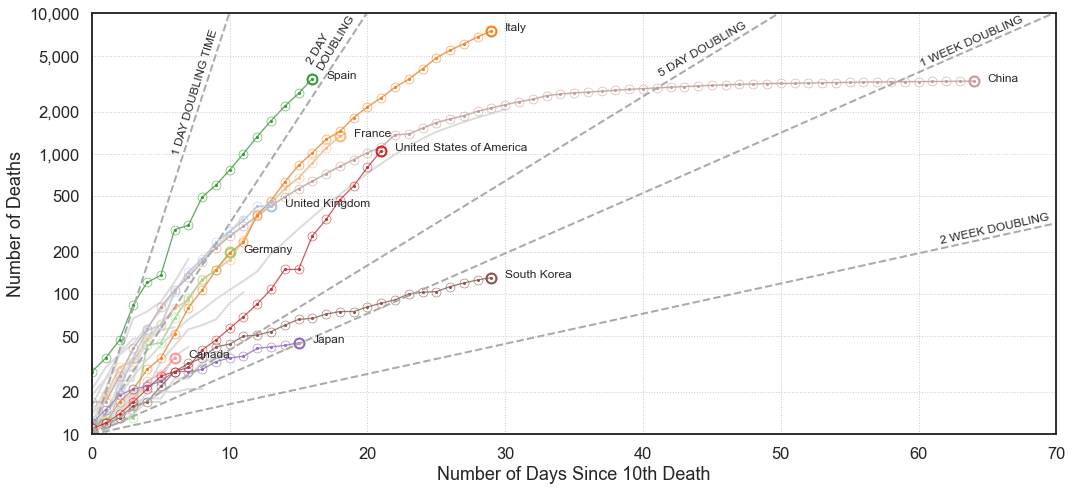

In [9]:
day_zero_col, cum_col = 'day_zero_deaths', 'cum_deaths_log10'

fig, ax = plt.subplots(figsize=(15, 7))

# Plot for all countries but using a faded grey; this plot effectively serves as an unlabaled background to 
# create a sense of how the other countries are progressing.
df[df['country'].isin(all_countries)].groupby('country').apply(
    lambda g: plot_simple_country_by_day(ax, g.set_index(day_zero_col)[cum_col], lw=2, c='gainsboro', alpha=1)
)


# An annotated plot for the set of highlight countries.
df[df['country'].isin(highlight_countries)].groupby('country').apply(
    lambda g: plot_country_by_day(ax, g.set_index(day_zero_col)[cum_col], label=g.name, c=highlight_colour_dict[g.name])
)


# Add the doubling-time indicators
def doubling_time(e, d):
    x = np.arange(0, e, d)
    y = np.log10((2**(x/d))*10)
    return x, y

for d in [1, 2, 5, 7, 14]: ax.plot(*doubling_time(71, d), c='darkgrey', lw=2, ls='--')

ax.annotate("1 DAY DOUBLING TIME", xy=(5.75, 3), fontsize=12, rotation=73)
ax.annotate("2 DAY\nDOUBLING", xy=(15.5, 3.6), fontsize=12, rotation=59)
ax.annotate("5 DAY DOUBLING", xy=(41, 3.55), fontsize=12, rotation=30)
ax.annotate("1 WEEK DOUBLING", xy=(60, 3.62), fontsize=12, rotation=24)
ax.annotate("2 WEEK DOUBLING", xy=(61.5, 2.36), fontsize=12, rotation=12.5)


# Labels and axes
ax.set_xlabel('Number of Days Since 10th Death')
ax.set_ylabel('Number of Deaths')

ax.set_xlim(0, 70)
ax.set_ylim(2, 4)

yticks = np.array([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
yticks_log10 = np.log10(yticks)

ax.set_yticks(yticks_log10)
ax.set_yticklabels([format(num, ',') for num in yticks])


ax.grid(b=True, lw=1, ls=':')


plt.tight_layout()

In [10]:
fig.savefig(graphs_dir+'deaths_by_days_for_countries.png', format='png', dpi=300)

# Summary Grid of Country Plots

In [36]:
def plot_countries_grid(countries, day_zero_col, cum_col, xlabel, ylabel, xticks, yticks, ylim, max_days, graph_size=2.5, ncols=6):
    
    nrows = 1+len(countries)//ncols if len(countries)%ncols>0 else len(countries)//ncols

    fig, axs = plt.subplots(figsize=(ncols*graph_size, nrows*graph_size), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

    flattened_axs = axs.flatten()

    for country, ax in zip(countries, flattened_axs):

        # Plot all countries in grey as a background against the current country.
        df[df['country'].isin(countries)].groupby('country').apply(
            lambda g: plot_simple_country_by_day(ax, g.set_index(day_zero_col)[cum_col], lw=1.5, c='gainsboro', alpha=1)
        )

        # Highlight the current country.
        s = df[df['country']==country].set_index(day_zero_col)[cum_col]  # The data to plot

        plot_simple_country_by_day(ax, s, lw=2, c='maroon')  # Plot the cases

        ax.plot([s.tail(1).index[0]], [s.tail(1).values[0]], c='maroon', marker='o', markersize=5)  # Mark the head

        
        xoffset, yoffset = 1, .2

        # If the country name is multipart then just use the initials.
        short_name = country.replace('_', ' ').title() if len(country.split('_'))<3 else ''.join([word[0] for word in country.split('_') if word[0].isupper()])
        ax.annotate(short_name, xy=(s.tail(1).index[0]+xoffset, s.tail(1).values[0]+yoffset), fontsize=14)

        yticks_log10 = np.log10(yticks)

        ax.set_ylim(*ylim)
        
        ax.set_yticks(yticks_log10)
        ax.set_yticklabels(['{}k'.format(n) for n in yticks//1000], fontsize=14)

        ax.grid(b=True, lw=1, ls=':')

    
    # Remove frames/axes from empty graphs
    empty_frames = len(countries)-len(flattened_axs)
    if empty_frames<0: 
        for ax in flattened_axs[empty_frames:]: ax.axis('off')

    for row in range(nrows): axs[row, 0].set_ylabel(ylabel, fontsize=16)
    for col in range(ncols):
        axs[0, col].set_xlabel(xlabel, fontsize=16)
        axs[0, col].set_xlim(0, max_days)
        axs[0, col].set_xticks(xticks)
        axs[0, col].set_xticklabels(xticks, fontsize=14)
        axs[0, col].xaxis.tick_top()
        axs[0, col].xaxis.set_label_position('top') 
        axs[0, col].xaxis.set_ticks_position('top')
        axs[nrows-1, col].set_xlabel(xlabel, fontsize=16)

    fig.tight_layout()
    
    return fig, axs




## Grid of Cases Plots

In [37]:
with_100_cases = df.groupby('country')['cum_cases'].max()>=100

countries_with_100_cases = with_100_cases[with_100_cases].index.values
len(countries_with_100_cases)

90

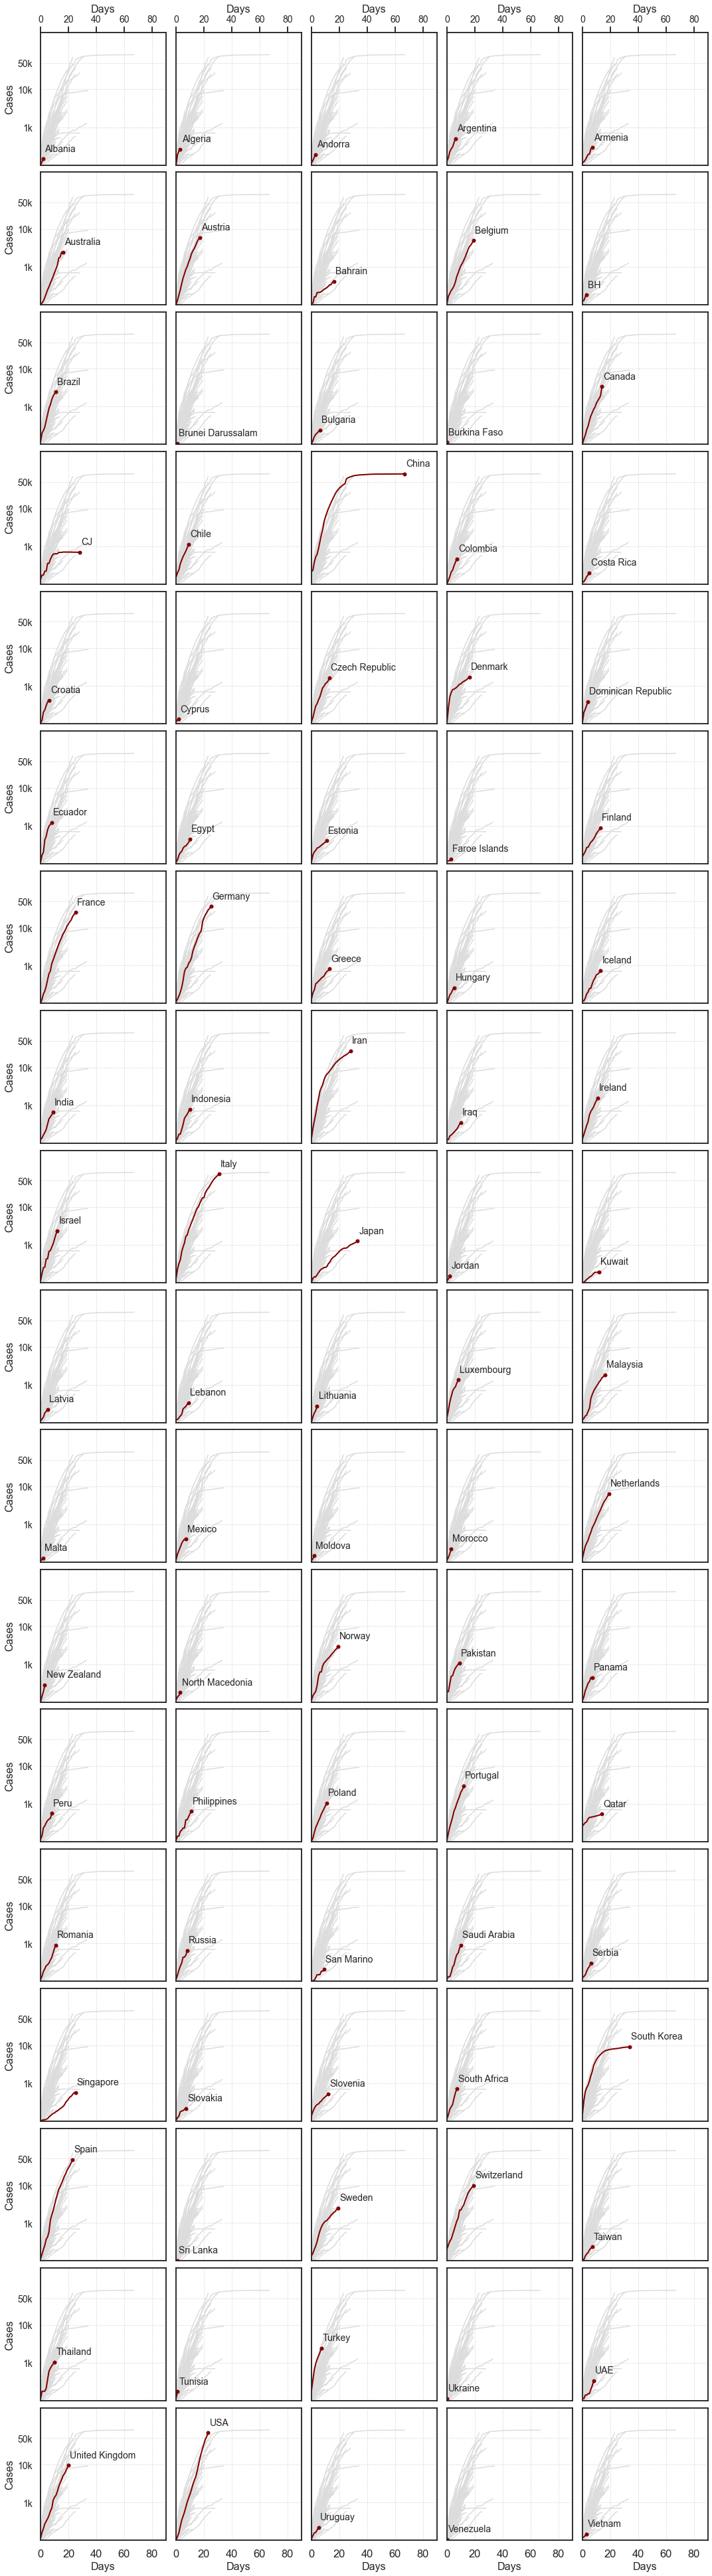

In [38]:
max_days = 90

fig, axs = plot_countries_grid(
    countries_with_100_cases, 
    'day_zero_cases', 'cum_cases_log10', 'Days', 'Cases', 
    range(0, max_days, 20), np.array([1000, 10000, 50000]), (2, 5.5), 
    max_days, graph_size=3, ncols=5
);


In [39]:
fig.savefig(graphs_dir+'grid_cases_by_days_for_countries.png', format='png', dpi=300)

## Grid of Deaths Plots

In [40]:
with_10_deaths = df.groupby('country')['cum_deaths'].max()>=10

countries_with_10_deaths = with_10_deaths[with_10_deaths].index.values
len(countries_with_10_deaths)

35

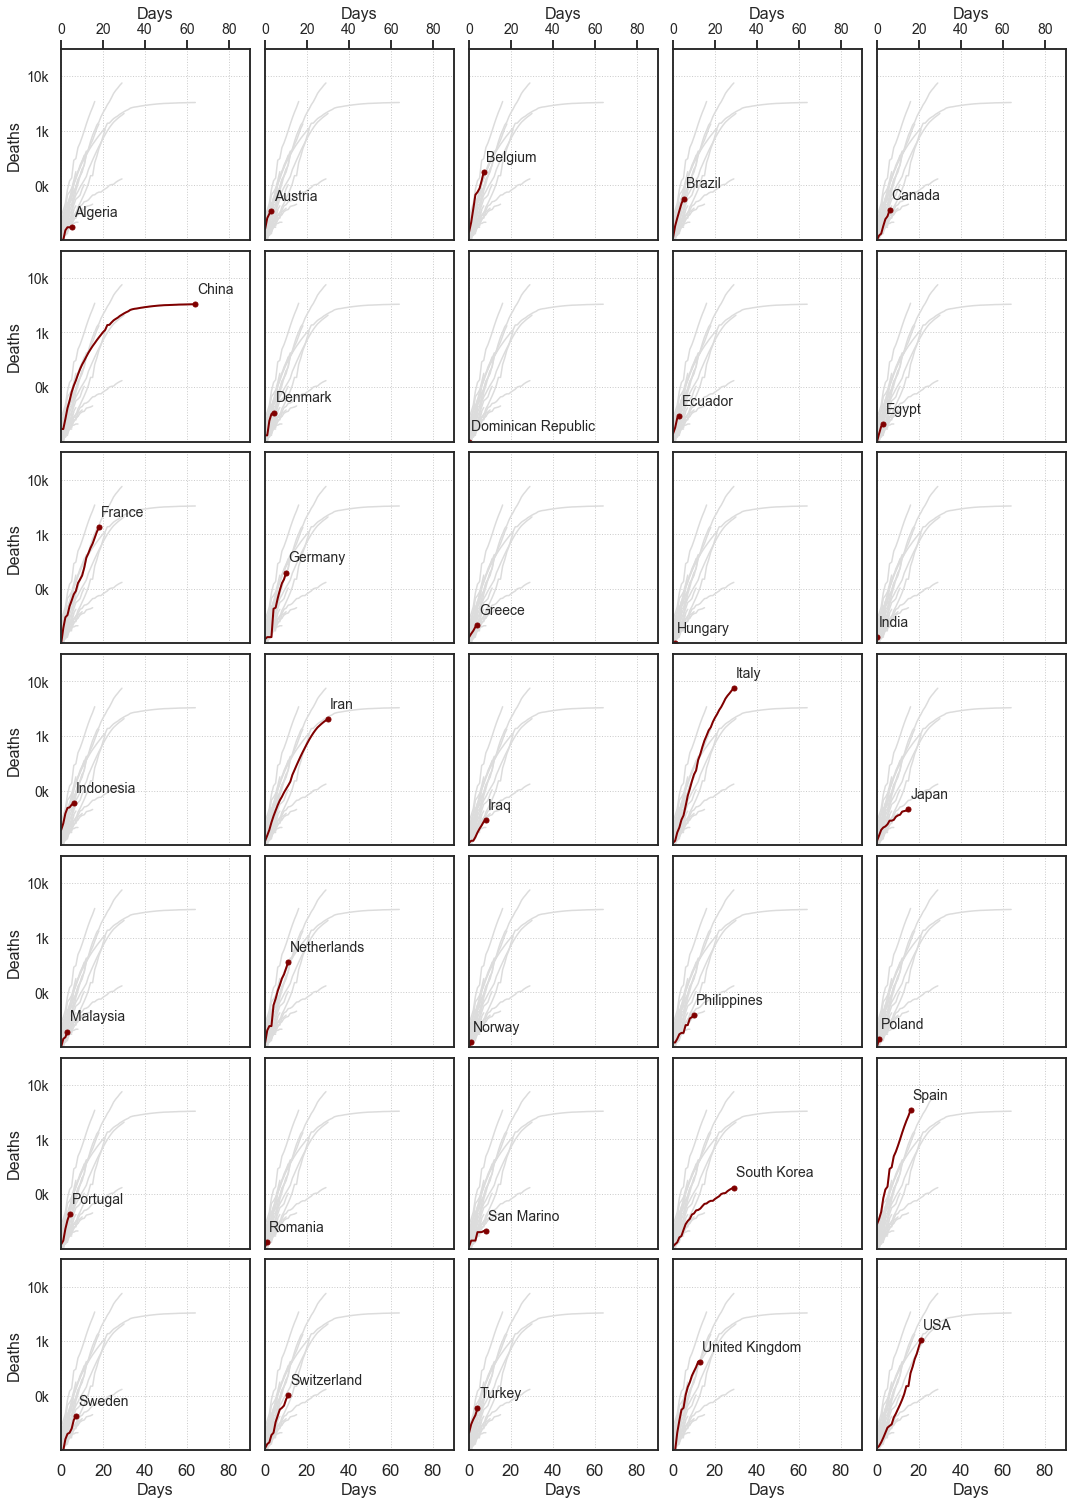

In [41]:
fig, axs = plot_countries_grid(
    countries_with_10_deaths, 
    'day_zero_deaths', 'cum_deaths_log10', 'Days', 'Deaths', 
    range(0, max_days, 20), np.array([100, 1000, 10000]), (1, 4.5), 
    max_days, graph_size=3, ncols=5
);


In [42]:
fig.savefig(graphs_dir+'grid_deaths_by_days_for_countries.png', format='png', dpi=300)